# Table of Contents:

* [REVIEW](#review)

* [EDA](#eda)

* [PROBLEM 1](#problem1): Estimate of causal effects: `Treatment on dANB`
     - [Task 1](#task1): Selection of covariates to adjust for (informed by the graph)
     - [Task 2](#task2): Application of the most suitable adjustment method
     - [Task 3](#task3): Estimates of the ATE
     - [Task 4](#task4): Estimates of the ATET
   
* [PROBLEM 2](#problem2): Estimate of causal effects: `Treatment on Growth`
    - [Task 1](#task2_1) Selection of covariates to adjust for (informed by the graph)
    - [Task 2](#task2_2) Application of the most suitable adjustment method
    - [Task 3](#task2_3) Estimates of the ATE
    - [Task 4](#task2_4) Estimates of the ATET


---

# Review <a class="anchor" id="review"></a>
In this assignment you are going to analyse scull measurement data of patients with malocclusion. Patients affected by Class III malocclusion (characterised by the protrusion of lower dental arch) suffer from a skeletal imbalance that is established early in life, and that becomes more pronounced during puberty and until skeletal maturation is complete. Predicting treatment success or failure early in a single Class III patient makes it easier to correct it, but it is difficult to do just from a small number of morphometric determinants is problematic. The reason for that is that Class III malocclusion is rarely a consequence of an abnormality in a single craniofacial component, so individual clinical and radiological measurements are likely to be less indicative than the interplay between the measurements themselves.

The data set we will use contains 143 patients with two sets of measurements at ages T1 and T2 (measured in years) for the following variables:
- `Treatment`: untreated (0) or treated (1).
- `Growth`: a binary variable with values Good or Bad, determined on the basis of CoGn-CoA.
- `ANB`: angle between Down's points A and B (degrees).
- `IMPA`: incisor-mandibular plane angle (degrees).
- `PPPM`: palatal plane - mandibular plane angle (degrees).
- `CoA`: total maxillary length from condilion to Down's point A (mm).
- `GoPg`: length of mandibular body from gonion to pogonion (mm).
- `CoGo`: length of mandibular ramus from condilion to pogonion (mm).
- `dT`: the difference between T2 and T1
- `Unobserved Confounders`: some variables for which there is no observation data.

For simplicity, we transform the dataset by taking differences between time points T2 and T1, so all features now represent changes in measurements.

All the measurements are taken from x-ray scans using a set of reference points established using a map.


We would like to estimate the effect of the treatment on Growth and dANB by taking into account causal relationships between variables. Our knowledge of those causal relationships is represented on the following DAG:

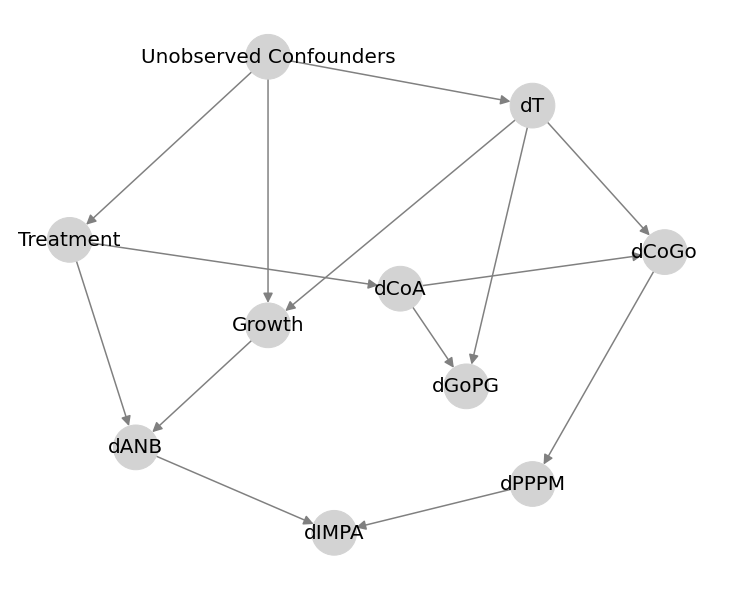

In [116]:
import networkx as nx
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10, 8

Graph = nx.DiGraph(directed=True, strict=True)

Graph.add_node('Treatment', pos = (-2, 0), color = 'lightgrey')
Graph.add_node('Growth', pos = (-1.4, -0.7), color = 'lightgrey')
Graph.add_node('dANB', pos = (-1.8, -1.7), color = 'lightgrey')
Graph.add_node('dIMPA', pos = (-1.2, -2.4), color = 'lightgrey')
Graph.add_node('dPPPM', pos = (-0.6, -2), color = 'lightgrey')
Graph.add_node('dCoA', pos = (-1, -0.4), color = 'lightgrey')
Graph.add_node('dGoPG', pos = (-0.8, -1.2), color = 'lightgrey')
Graph.add_node('dCoGo', pos =  (-0.2, -0.1), color = 'lightgrey')
Graph.add_node('dT', pos = (-0.6, 1.1), color = 'lightgrey')
Graph.add_node('Unobserved Confounders', pos = (-1.4, 1.5), color = 'lightgrey')

Graph.add_edges_from(
    [('Unobserved Confounders', 'Growth'), ('Unobserved Confounders', 'Treatment'),
     ('Unobserved Confounders', 'dT'), ('Growth', 'dANB'), ('dANB', 'dIMPA'),
     ('Treatment', 'dANB'), ('Treatment', 'dCoA'), ('dCoA', 'dCoGo'), ('dCoA', 'dGoPG'),
     ('dT', 'Growth'), ('dT', 'dCoGo'), ('dT', 'dGoPG'), ('dCoGo', 'dPPPM'), ('dPPPM', 'dIMPA')]
)

position = nx.get_node_attributes(Graph, 'pos')
color_node = nx.get_node_attributes(Graph, 'color')
color = [color_node[i] for i in Graph.nodes()]
options = {'node_size': 2000, 'width': 1.5, 'arrowstyle': '-|>', 'arrowsize': 20, 'font_size' : 20}

nx.draw(Graph, position, with_labels=True, arrows=True, **options, node_color=color, edge_color = 'grey')


Treatment assignment, Growth and number of years between two measurements are likely to be affected by some unobserved confounders, as the graph shows. 

Given the graph, select the variables to condition on, apply suitable adjustment method, and calculate your estimates of causal effects: Treatment on Growth, Treatment on dANB, both ATE and ATET.

### References:

The dataset is taken from:  
`Scutari, M., Auconi, P., Caldarelli, G., Franchi, L. (2017) Bayesian Networks Analysis of Malocclusion Data. Scientific Reports, 7, 15236`


---



# Exploratory Data Analysis (EDA) <a class="anchor" id="eda"></a>

In [117]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import statsmodels.api as sm

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from causalinference import CausalModel

Let's load the dataset and see its key statistical parameters, as well as the cross-correlations between the variables:

In [118]:
data = pd.read_csv('malocclusion.csv', sep=',')
data.head()

,dANB,dPPPM,dIMPA,dCoA,dGoPg,dCoGo,dT,Growth,Treatment
0,-3.2,-1.1,-4.2,1.0,4.0,3.7,5,0,0
1,-0.6,-0.5,3.8,2.6,-0.1,1.4,3,1,0
2,-1.6,-3.1,-6.0,4.3,4.2,7.1,5,0,0
3,-1.1,-2.1,-12.1,14.1,20.7,17.5,9,0,0
4,-1.1,0.0,-6.7,7.7,8.8,11.0,5,0,0


In [119]:
data.describe()

,dANB,dPPPM,dIMPA,dCoA,dGoPg,dCoGo,dT,Growth,Treatment
count,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000
mean,-0.227273,-1.374825,-0.785315,5.987413,7.730769,6.732867,4.706294,0.405594,0.461538
std,1.826225,2.715046,5.080894,4.469692,5.532417,4.595141,2.550427,0.492733,0.500271
min,-5.100000,-9.300000,-19.000000,-0.900000,-1.400000,-2.600000,1.000000,0.000000,0.000000
25%,-1.350000,-2.750000,-3.450000,1.800000,3.200000,3.050000,3.000000,0.000000,0.000000
50%,-0.300000,-1.400000,-0.400000,5.500000,6.200000,6.300000,4.000000,0.000000,0.000000
75%,0.950000,0.050000,2.100000,9.750000,12.750000,10.350000,6.000000,1.000000,1.000000
max,4.900000,6.500000,12.000000,20.000000,23.300000,17.500000,12.000000,1.000000,1.000000


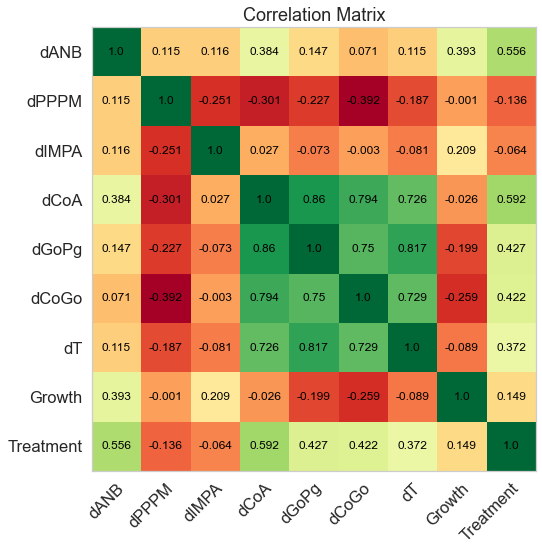

In [120]:
correlation_matrix = data.corr()
columns = data.columns.to_list()

fig, ax = plt.subplots()
ax.imshow(correlation_matrix, cmap='RdYlGn')

n = len(columns)

ax.set_xticks(np.arange(n))
ax.set_yticks(np.arange(n))

ax.set_xticklabels(columns)
ax.set_yticklabels(columns)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(n):
    for j in range(n):
        text = ax.text(j, i, round(correlation_matrix[columns[i]][columns[j]], 3),
                       ha="center", va="center", color="black", size = 12)

ax.set_title("Correlation Matrix")
fig.tight_layout()
ax.grid(False)
plt.show()

---



## PROBLEM 1: Estimate of causal effects: `Treatment on dANB` <a class="anchor" id="problem1"></a>

### Task 1: Selection of covariates to adjust for (informed by the graph) <a class="anchor" id="task1"></a>

1.1.1. When estimating the causal inference of `Treatment` on `dANB`, we have two non-directed paths that can have a latent influence:
* `Treatment` <- `Unobserved Confounders` -> `Growth` -> `dANB`
* `Treatment` <- `Unobserved Confounders` -> `dT` -> `Growth` -> `dANB`

1.1.2. All other paths from `Treatment` to `dANB` are d-separated because they are blocked by the following colliders:
* `dGoPg`
* `dCoGo`
* `dIMPA`

1.1.3. For the non-directed paths listed above, we have the following adjustment sets:
* {`Growth`}
* {`Growth`, `dT`}

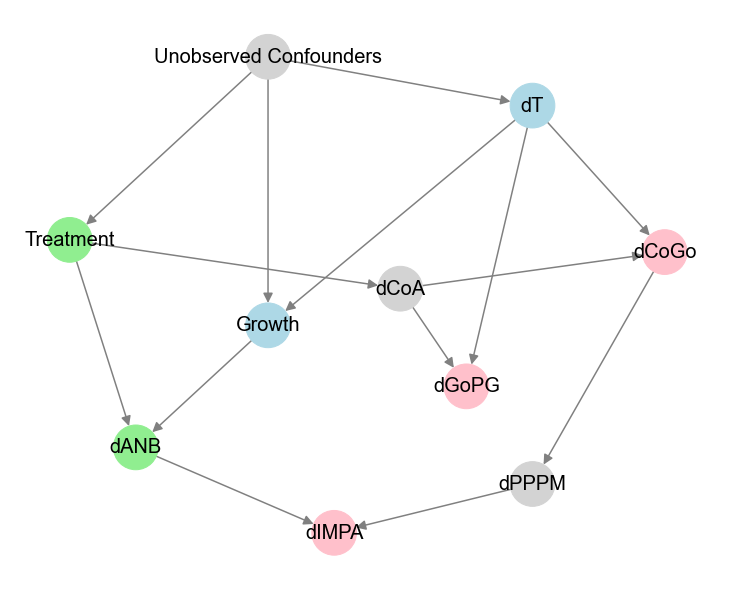

In [121]:
Graph = nx.DiGraph(directed=True, strict=True)

Graph.add_node('Treatment', pos = ( -2,0), color = 'lightgreen')
Graph.add_node('Growth', pos = (-1.4, -0.7), color = 'lightblue')
Graph.add_node('dANB', pos = (-1.8, -1.7), color = 'lightgreen')
Graph.add_node('dIMPA', pos = (-1.2, -2.4), color = 'pink')
Graph.add_node('dPPPM', pos = (-0.6, -2), color = 'lightgrey')
Graph.add_node('dCoA', pos = (-1, -0.4), color = 'lightgrey')
Graph.add_node('dGoPG', pos = (-0.8, -1.2), color = 'pink')
Graph.add_node('dCoGo', pos =  (-0.2, -0.1), color = 'pink')
Graph.add_node('dT', pos = (-0.6, 1.1), color = 'lightblue')
Graph.add_node('Unobserved Confounders', pos = (-1.4, 1.5), color = 'lightgrey')

Graph.add_edges_from(
    [('Unobserved Confounders', 'Growth'), ('Unobserved Confounders', 'Treatment'),
     ('Unobserved Confounders', 'dT'), ('Growth', 'dANB'), ('dANB', 'dIMPA'),
     ('Treatment', 'dANB'), ('Treatment', 'dCoA'), ('dCoA', 'dCoGo'), ('dCoA', 'dGoPG'),
     ('dT', 'Growth'), ('dT', 'dCoGo'), ('dT', 'dGoPG'), ('dCoGo', 'dPPPM'), ('dPPPM', 'dIMPA')]
)

position = nx.get_node_attributes(Graph, 'pos')
color_node = nx.get_node_attributes(Graph, 'color')
color = [color_node[i] for i in Graph.nodes()]
options = {'node_size': 2000, 'width': 1.5, 'arrowstyle': '-|>', 'arrowsize': 20, 'font_size' : 20}

nx.draw(Graph, position, with_labels=True, arrows=True, **options, node_color=color, edge_color = 'grey')


1.1.4. We would like to take the smallest adjustment set for several reasons:
* There are few observations in the dataset, so the use of a large number of variables can get to unstable results;
* Variables can correlate with each other (multicollinearity);
* `dT` has a low correlation with outcome `dANB` (0.115).


But we also see that the `dT` has a low correlation with `Growth` (-0.089), so let's try to check which of the two adjustment sets is optimal in terms of the quality of evaluating the impact of `Treatment` on `dANB`. To do this, we will build two regressions on adjustment sets {`Growth`} and {`Growth`, `dT`}.

In [122]:
# Regression on 'Growth' and 'Treatment'

m = smf.ols('dANB ~ Growth + Treatment', data=data)
fitted = m.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                   dANB   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     48.04
Date:                Tue, 12 Oct 2021   Prob (F-statistic):           1.31e-16
Time:                        22:54:40   Log-Likelihood:                -251.17
No. Observations:                 143   AIC:                             508.3
Df Residuals:                     140   BIC:                             517.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5600      0.181     -8.609      0.0

In [123]:
# Regression on 'Growth', 'dT', and 'Treatment'

m = smf.ols('dANB ~ Growth + dT + Treatment', data=data)
fitted = m.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                   dANB   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     32.12
Date:                Tue, 12 Oct 2021   Prob (F-statistic):           7.78e-16
Time:                        22:54:43   Log-Likelihood:                -250.87
No. Observations:                 143   AIC:                             509.7
Df Residuals:                     139   BIC:                             521.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4021      0.276     -5.075      0.0

### Conclusions:

1. We see that both regressions give approximately the same results for `R2` (0.407 vs. 0.409) and `Adj.R2` (0.398 vs. 0.397). Since we have few observations, it is better for us to focus on `Adj.R2` (with a large number of observations, `Adj.R2` will asymptotically converge to `R2`);
2. We also see that the variable `dT` has a statistically insignificant coefficient in the second regression (zero is contained in the confidence interval).


So let's use the smallest adjustment set {`Growth`} (guided by Occam's razor principle).  
In addition, the smallest adjustment set will allow us to apply `"1:1" matching` as the most accurate method for estimating `ATET`.

### Task 2: Application of the most suitable adjustment method <a class="anchor" id="task2"></a>

1.2.1. Since we have only one variable in the ajusted set and little data, the `Linear Regression` is suitable for estimating `ATE`.  
We will also try to use the `Doubly Robust Procedure` and choose the best result.

### Regression (for ATE)

In [124]:
# Regression 
# X-set: {`Growth`}

m = smf.ols('dANB ~ Growth + Treatment', data=data)
fitted = m.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                   dANB   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     48.04
Date:                Tue, 12 Oct 2021   Prob (F-statistic):           1.31e-16
Time:                        22:54:47   Log-Likelihood:                -251.17
No. Observations:                 143   AIC:                             508.3
Df Residuals:                     140   BIC:                             517.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5600      0.181     -8.609      0.0

ATE by Regression is 1.8560  
Confidence interval is $[$1.381, 2.331$]$

### Doubly robust estimator (for ATE)

In [125]:
# Doubly Robust Procedure
# X-set: {`Growth`}

cls = LogisticRegression()

# calibration of the classifier
cls = CalibratedClassifierCV(cls)

X = data[['Growth']]
y = data['Treatment']
cls.fit(X, y)

data['e'] = cls.predict_proba(X)[:,1].tolist()
data.head()
data['w'] = data['Treatment'] / data['e'] + (1 - data['Treatment']) / (1 - data['e'])

y0 = LinearRegression().fit(data[data.Treatment == 0][['Growth']], 
                            data[data.Treatment == 0]['dANB']).predict(data[['Growth']])
y1 = LinearRegression().fit(data[data.Treatment == 1][['Growth']], 
                            data[data.Treatment == 1]['dANB']).predict(data[['Growth']])

data['DR0'] = (1-data['Treatment']) * (data['dANB'] - y0)/(1-data['e']) + y0
data['DR1'] =    data['Treatment']  * (data['dANB'] - y1)/   data['e']  + y1

print('ATE by Doubly_Robust_Procedure is', round(data['DR1'].mean() - data['DR0'].mean(), 4))


ATE by Doubly_Robust_Procedure is 1.8564


1.2.2. We got close estimates of the causal inference for `Regression` and `Double Robust`.  
Let's use a boostrap to estimate the confidence interval of the **`ATE`** estimate by `Double Robust`.

In [126]:
def get_bootstrap_samples(x, n):
    indices = np.random.randint(0, len(x), (n, len(x)))
    resamples = x[indices]
    return resamples

def percentile_interval(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [127]:
n = 1000 # number of samples
ATE_bootstrap = []

for i in range(n):
    sample = data.sample(frac=1, replace = True).reset_index(drop=True)
    
    cls = LogisticRegression()
    cls = CalibratedClassifierCV(cls)

    X = sample[['Growth']]
    y = sample['Treatment']
    cls.fit(X, y)

    sample['e'] = cls.predict_proba(X)[:,1].tolist()
    sample['w'] = sample['Treatment'] / sample['e'] + (1 - sample['Treatment']) / (1 - sample['e'])
    
    y0 = LinearRegression().fit(sample[sample.Treatment == 0][['Growth']], 
                                sample[sample.Treatment == 0]['dANB']).predict(sample[['Growth']])
    y1 = LinearRegression().fit(sample[sample.Treatment == 1][['Growth']], 
                                sample[sample.Treatment == 1]['dANB']).predict(sample[['Growth']])

    sample['DR0'] = (1-sample['Treatment']) * (sample['dANB'] - y0)/(1-sample['e']) + y0
    sample['DR1'] =    sample['Treatment']  * (sample['dANB'] - y1)/   sample['e']  + y1

    ATE_bootstrap.append(sample['DR1'].mean() - sample['DR0'].mean())
    
np.random.seed(0)
ATE_mean = list(map(np.mean, get_bootstrap_samples(np.array(ATE_bootstrap), 1000)))

print('ATE_mean:\t\t', round(np.mean(ATE_bootstrap), 3))
print("95% conf_int:\t",  percentile_interval(ATE_mean, 0.05))

ATE_mean:		 1.863
95% conf_int:	 [1.84571325 1.8783292 ]


1.2.3. To estimate `ATET` we will use `"1:1" matching` on the selected adjustment set, since the variables `Growth` and `Treatment` are binary and the number of matching pairs should cover the sample very well.  
We will also try to use `Mahalanobis Distance` and `Propensity Score` to increase the sample coverage.  
We will choose the best result after comparing the methods.

### Matching "1:1" (for ATET)

1.2.4. Since `"1:1" matching` is a greedy algorithm, we will use a bootstrap to form different pairs and average the result.

In [128]:
n = 1000 # number of samples
ATET_bootstrap = []
columns_list = [i+'_t0' for i in data.columns]

for i in range(n):
    sample = data.sample(frac=1).reset_index(drop=True)
    data_g0 = sample[(sample['Treatment'] == 0) & (sample['Growth'] == 0)][:34]
    data_g1 = sample[(sample['Treatment'] == 0) & (sample['Growth'] == 1)][:32]

    data_g0.columns = columns_list
    data_g1.columns = columns_list

    data_tr_0 = sample[(sample['Treatment'] == 1) & (sample['Growth'] == 0)]
    data_tr0 = pd.concat([data_g0.reset_index(), data_tr_0.reset_index()], axis = 1)

    data_tr_1 = sample[(sample['Treatment'] == 1) & (sample['Growth'] == 1)]
    data_tr1 = pd.concat([data_g1.reset_index(), data_tr_1.reset_index()], axis = 1)

    matches = pd.concat([data_tr0, data_tr1], axis = 0)

    matches['diff_t1_t0'] = matches['dANB'] - matches['dANB_t0']
    ATET_bootstrap.append(matches['diff_t1_t0'].mean())

    
np.random.seed(0)
ATET_mean = list(map(np.mean, get_bootstrap_samples(np.array(ATET_bootstrap), 1000)))

print('ATET (ATT):\t', round(np.mean(ATET_bootstrap), 3))
print("95% conf_int:\t",  percentile_interval(ATET_mean, 0.05))

ATET (ATT):	 1.852
95% conf_int:	 [1.84669287 1.85849958]


In [129]:
UTU = matches[matches['dANB_t0'].isna()].shape[0]
MTU = matches[~matches['dANB_t0'].isna()].shape[0]
UTUp = round((UTU / (UTU + MTU) * 100), 1)
MTUp = round((MTU / (UTU + MTU) * 100), 1)

mt_m = round(matches[~matches['dANB_t0'].isna()]['dANB'].mean(), 3)
mt_u = round(matches[matches['dANB_t0'].isna()]['dANB'].mean(), 3)
mt_all = round(matches['dANB'].mean(), 3)

UCU = abs(data[data['Treatment']== 0].Growth.value_counts()[0] - data[data['Treatment'] == 1].Growth.value_counts()[0])
MCU = data[data['Treatment']== 0].Growth.value_counts()[0] + data[data['Treatment']== 0].Growth.value_counts()[1] - UCU
UCUp = round((UCU / (UCU + MCU) * 100), 1)
MCUp = round((MCU / (UCU + MCU) * 100), 1)

mс_m = round(matches[~matches['dANB_t0'].isna()]['dANB_t0'].mean(), 3)
mс_u = round(matches[matches['dANB_t0'].isna()]['dANB_t0'].mean(), 3)
mс_all = round(data[(data['Treatment'] == 0)]['dANB'].mean(), 3)

print('\t\t\t\t# \t%\t   mean_Y')
print('-----------------------------------------------------------')
print(f'Matched Treatment Units\t\t{MTU}\t{MTUp}%\t   {mt_m}')
print(f'Unmatched Treatment Units\t{UTU}\t{UTUp}%\t')
print(f'All Treatment Units\t\t{UTU+MTU}\t{UTUp+MTUp}%\t   {mt_all}')
print('')
print(f'Matched Control Units\t\t{MCU}\t{MCUp}%\t  {mс_m}')
print(f'Unmatched Control Units\t\t{UCU}\t{UCUp}%')
print(f'All Control Units\t\t{UCU+MCU}\t{UCUp+MCUp}%\t  {mс_all}')
print('-----------------------------------------------------------')
print('ATET (ATT):\t\t\t\t', round(np.mean(ATET_bootstrap), 3))
print("95% confidence interval:\t",  percentile_interval(ATET_mean, 0.05))


				# 	%	   mean_Y
-----------------------------------------------------------
Matched Treatment Units		60	90.9%	   0.845
Unmatched Treatment Units	6	9.1%	
All Treatment Units		66	100.0%	   0.865

Matched Control Units		60	77.9%	  -1.117
Unmatched Control Units		17	22.1%
All Control Units		77	100.0%	  -1.164
-----------------------------------------------------------
ATET (ATT):				 1.852
95% confidence interval:	 [1.84669287 1.85849958]


### Matching with Mahalanobis distance (for ATE and ATET)

In [148]:
# Mahalanobis distance

from causalinference import CausalModel
adjustment_set = ['Growth']

causal = CausalModel(
    Y=data['dANB'].values, # outcome
    D=data['Treatment'].values, # treatment
    X=data[adjustment_set].values
)

causal.est_via_matching(bias_adj=True)
print(causal.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      1.856      0.237      7.829      0.000      1.392      2.321
           ATC      1.860      0.240      7.761      0.000      1.390      2.330
           ATT      1.852      0.240      7.723      0.000      1.382      2.322



### Propensity score matching (for ATET)

In [131]:
# Propensity score

causal = CausalModel(
    Y=data['dANB'].values, # outcome
    D=data['Treatment'].values, # treatment
    X=data['e'].values
)
causal.est_via_matching(bias_adj=True)
print(causal.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      1.856      0.237      7.829      0.000      1.392      2.321
           ATC      1.860      0.240      7.761      0.000      1.390      2.330
           ATT      1.852      0.240      7.723      0.000      1.382      2.322



### Conclusions:

1. We see that `Regression`, `Doubly Robust Procedure`, `Mahalanobis distance`, and `Propensity score` give similar **`ATE`**.   
We selected `Doubly Robust Procedure` to calculate **`ATE`**.


2. We also see that `Matching "1:1"`, `Mahalanobis distance`, and `Propensity score` give similar **`ATET`**.  
We selected `Matching "1:1"` to calculate **`ATET`**.

### Task 3: Estimates of the ATE <a class="anchor" id="task3"></a>
(by `Doubly robust procedure`)

**`ATE`** = **1.856**

95% confidence interval for `ATE_mean`:  $[$1.8457, 1.8783$]$


### Task 4: Estimates of the ATEТ <a class="anchor" id="task4"></a>
(by `Matching "1:1"`)

**`ATET`**: = **1.852**

95% confidence interval for `ATET_mean`:  $[$1.8467, 1.8585$]$


---


## PROBLEM 2: Estimate of causal effects: `Treatment on Growth` <a class="anchor" id="problem2"></a>

### Task 1: Selection of covariates to adjust for (informed by the graph) <a class="anchor" id="task2_1"></a>

2.1.1. We see that the link from `Treatment` to `Growth` is not drawn on the DAG, which may means that the researchers who created this DAG believe that there is no relationship or it is statistically insignificant.  
Let's try to check if there is a causal between these variables or not.

2.1.2. If we make the link from `Treatment` to `Growth`, we get two non-direct paths:
* `Treatment` <- `Unobserved Confounders` -> `Growth`
* `Treatment` <- `Unobserved Confounders` -> `dT` -> `Growth`

2.1.3. All other paths from `Treatment` to `dANB` are d-separated because they are blocked by the following colliders:
* `dGoPg`
* `dCoGo`
* `dIMPA`

2.1.4. Both non-directed paths pass through the variable `Unobserved Confounders`, which is unobserved (there are no observations for it).  
Therefore, the non-directed path `Treatment <- Unobserved Confounders -> Growth` cannot be blocked.  
And we cannot select an adjustment set for the estimating `ATE`.  
Let's see what we can do.

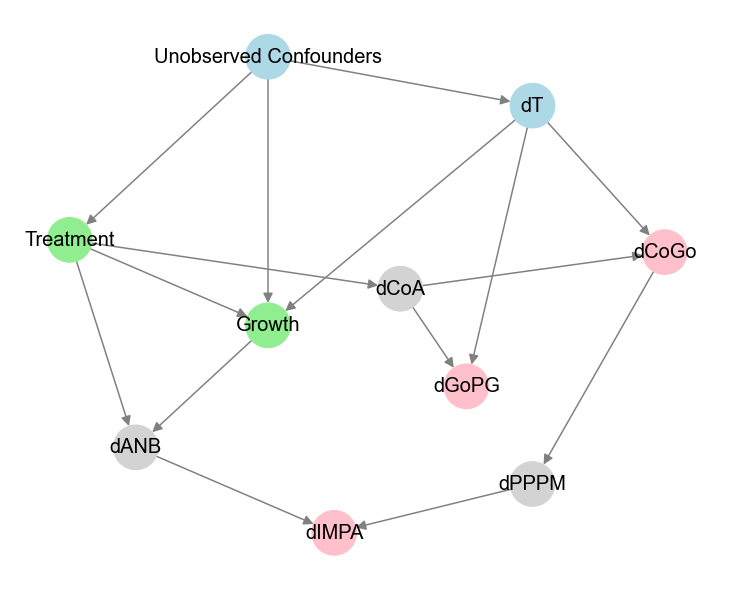

In [132]:
Graph = nx.DiGraph(directed=True, strict=True)

Graph.add_node('Treatment', pos = ( -2,0), color = 'lightgreen')
Graph.add_node('Growth', pos = (-1.4, -0.7), color = 'lightgreen')
Graph.add_node('dANB', pos = (-1.8, -1.7), color = 'lightgrey')
Graph.add_node('dIMPA', pos = (-1.2, -2.4), color = 'pink')
Graph.add_node('dPPPM', pos = (-0.6, -2), color = 'lightgrey')
Graph.add_node('dCoA', pos = (-1, -0.4), color = 'lightgrey')
Graph.add_node('dGoPG', pos = (-0.8, -1.2), color = 'pink')
Graph.add_node('dCoGo', pos =  (-0.2, -0.1), color = 'pink')
Graph.add_node('dT', pos = (-0.6, 1.1), color = 'lightblue')
Graph.add_node('Unobserved Confounders', pos = (-1.4, 1.5), color = 'lightblue')

Graph.add_edges_from(
    [('Unobserved Confounders', 'Growth'), ('Unobserved Confounders', 'Treatment'),
     ('Unobserved Confounders', 'dT'), ('Growth', 'dANB'), ('dANB', 'dIMPA'), ('Treatment', 'Growth'),
     ('Treatment', 'dANB'), ('Treatment', 'dCoA'), ('dCoA', 'dCoGo'), ('dCoA', 'dGoPG'),
     ('dT', 'Growth'), ('dT', 'dCoGo'), ('dT', 'dGoPG'), ('dCoGo', 'dPPPM'), ('dPPPM', 'dIMPA')]
)

position = nx.get_node_attributes(Graph, 'pos')
color_node = nx.get_node_attributes(Graph, 'color')
color = [color_node[i] for i in Graph.nodes()]
options = {'node_size': 2000, 'width': 1.5, 'arrowstyle': '-|>', 'arrowsize': 20, 'font_size' : 20}

nx.draw(Graph, position, with_labels=True, arrows=True, **options, node_color=color, edge_color = 'grey')

### Task 2: Application of the most suitable adjustment method <a class="anchor" id="task2_2"></a>

2.2.1. Let's try to solve the problem through the `front-door formula`, finding the necessary `proxy-variable` (or `instrumental variable` in another terminology).  

Such a variable can be `dCOA` because it satisfies all `front-door` criteria:
1. `dCOA` intercepts all directed paths from `Treatment` to `Growth`;
2. There is no unblocked path from `Treatment` to `dCOA`;
3. All backdoor paths from `dCOA` to `Growth` are blocked by `Treatment`.  

All other paths from `dCOA` to `Growth` are blocked by colliders `dGoPG`, `dCoGo`, and `dIMPA`, i.e. do not have a latent effect on `Growth`.


If we make the link from `dCOA` to `Growth`, we can estimate causal inference `Treatment` on `Growth` through the `front-door formula`.



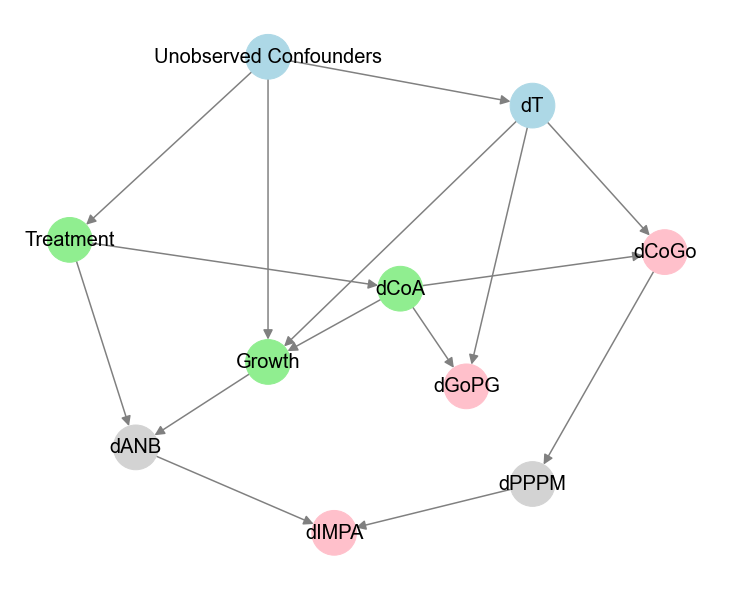

In [133]:
Graph = nx.DiGraph(directed=True, strict=True)

Graph.add_node('Treatment', pos = ( -2,0), color = 'lightgreen')
Graph.add_node('Growth', pos = (-1.4, -1), color = 'lightgreen')
Graph.add_node('dANB', pos = (-1.8, -1.7), color = 'lightgrey')
Graph.add_node('dIMPA', pos = (-1.2, -2.4), color = 'pink')
Graph.add_node('dPPPM', pos = (-0.6, -2), color = 'lightgrey')
Graph.add_node('dCoA', pos = (-1, -0.4), color = 'lightgreen')
Graph.add_node('dGoPG', pos = (-0.8, -1.2), color = 'pink')
Graph.add_node('dCoGo', pos =  (-0.2, -0.1), color = 'pink')
Graph.add_node('dT', pos = (-0.6, 1.1), color = 'lightblue')
Graph.add_node('Unobserved Confounders', pos = (-1.4, 1.5), color = 'lightblue')

Graph.add_edges_from(
    [('Unobserved Confounders', 'Growth'), ('Unobserved Confounders', 'Treatment'),
     ('Unobserved Confounders', 'dT'), ('Growth', 'dANB'), ('dANB', 'dIMPA'), ('dCoA', 'Growth'),
     ('Treatment', 'dANB'), ('Treatment', 'dCoA'), ('dCoA', 'dCoGo'), ('dCoA', 'dGoPG'),
     ('dT', 'Growth'), ('dT', 'dCoGo'), ('dT', 'dGoPG'), ('dCoGo', 'dPPPM'), ('dPPPM', 'dIMPA')]
)

position = nx.get_node_attributes(Graph, 'pos')
color_node = nx.get_node_attributes(Graph, 'color')
color = [color_node[i] for i in Graph.nodes()]
options = {'node_size': 2000, 'width': 1.5, 'arrowstyle': '-|>', 'arrowsize': 20, 'font_size' : 20}

nx.draw(Graph, position, with_labels=True, arrows=True, **options, node_color=color, edge_color = 'grey')

2.2.2. We will solve the problem through a proxy-variable (instrumental variable), so we will use the `front-door formula` for the `ATE` and `ATET` estimates.

### Task 3: Estimates of the ATE <a class="anchor" id="task2_3"></a>

2.3.1. We will use the implementation to evaluate the `ATE` using the front-door formula taken from the source:
http://www.degeneratestate.org/posts/2018/Sep/03/causal-inference-with-python-part-3-frontdoor-adjustment/

2.3.2. We will use a boostrap to estimate the confidence interval of the ATE estimate.

In [134]:
def estimate_ate_frontdoor_linear(df, x, y, z):
    """
    Estiamte the ATE of a system from a dataframe of samples `df`
    using frontdoor adjustment and assuming linear models.
    
    Arguments
    ---------
    df: pandas.DataFrame
    x: str
    y: str
    z: str
    
    Returns 
    -------
    ATE: float
    """
    x = df[x].values
    y = df[y].values
    z = df[z].values
    
    z_x_model = sm.OLS(z, sm.add_constant(x)).fit()
    
    z_bar = z_x_model.predict(sm.add_constant(x))
    z_prime = z - z_bar

    y_z_model = sm.OLS(y, sm.add_constant(z_prime)).fit()
    
    return (y_z_model.params[1] * z_x_model.params[1], y_z_model.params[1], z_x_model.params[1])

In [135]:
ATE = round(estimate_ate_frontdoor_linear(data, 'Treatment', 'Growth', 'dCoA')[0], 4)
print("ATE =", ATE)

ATE = -0.1028


In [136]:
n = 1000 # number of samples
ATE_bootstrap = []

for i in range(n):
    sample = data.sample(frac=1, replace = True).reset_index(drop=True)
    ATE_bootstrap.append(estimate_ate_frontdoor_linear(sample, 'Treatment', 'Growth', 'dCoA')[0])
    
np.random.seed(0)
ATE_mean = list(map(np.mean, get_bootstrap_samples(np.array(ATE_bootstrap), 1000)))

print('ATE_mean:\t\t', round(np.mean(ATE_bootstrap), 4))
print("95% conf_int:\t",  percentile_interval(ATE_mean, 0.05))

ATE_mean:		 -0.1025
95% conf_int:	 [-0.10585927 -0.09894599]


**`ATE`** = **-0.1028**

95% confidence interval for `ATE_mean`:  $[$-0.1059, -0.0989$]$


### Task 4: Estimates of the ATEТ <a class="anchor" id="task2_4"></a>

2.4.1. To estimate `ATET`, we will use main formula:

*ATET = E(Growth|do(T=1)) − E(Growth|do(T=0)) = P(Growth=1|do(T=1)) − P(Growth=1|do(T=0))*

And we need to calculate *P(Growth|do(T=1))* and *P(Growth|do(T=0))* using `dCoA`

In [137]:
min_ = round(data['dCoA'].min(), 4)
max_ = round(data['dCoA'].max(), 4)
print(f'min(dCoA) = {min_}')
print(f'max(dCoA) = {max_}')

min(dCoA) = -0.9
max(dCoA) = 20.0


2.4.2. Let's split the `dCoA` variable into 5 quantiles and create new variable:

In [138]:
quantiles = [-1]

for i in range(2, 10, 2):
    p = np.percentile(data['dCoA'], i*10)
    quantiles.append(p)
quantiles.append(20)
    
quantiles

[-1,
 1.5999999999999899,
 3.8200000000000096,
 7.340000000000001,
 10.480000000000002,
 20]

In [139]:
labels_q5 = [1, 2, 3, 4, 5]
data['q5_dCoA'] = pd.cut(data['dCoA'], bins=quantiles, labels=labels_q5)

In [140]:
data.head(10)

,dANB,dPPPM,dIMPA,dCoA,dGoPg,dCoGo,dT,Growth,Treatment,e,w,DR0,DR1,q5_dCoA
0,-3.2,-1.1,-4.2,1.0,4.0,3.7,5,0,0,0.34318,1.522486,-4.052369,0.308824,1
1,-0.6,-0.5,3.8,2.6,-0.1,1.4,3,1,0,0.42124,1.727833,-0.767961,1.456250,2
2,-1.6,-3.1,-6.0,4.3,4.2,7.1,5,0,0,0.34318,1.522486,-1.616392,0.308824,3
3,-1.1,-2.1,-12.1,14.1,20.7,17.5,9,0,0,0.34318,1.522486,-0.855149,0.308824,5
4,-1.1,0.0,-6.7,7.7,8.8,11.0,5,0,0,0.34318,1.522486,-0.855149,0.308824,4
5,-0.6,-0.9,-1.1,0.1,-1.0,0.9,3,1,0,0.42124,1.727833,-0.767961,1.456250,1
6,-1.2,-1.8,1.8,1.6,1.7,3.0,3,1,0,0.42124,1.727833,-1.804661,1.456250,1
7,-0.1,-2.3,1.6,2.5,4.1,0.1,2,1,0,0.42124,1.727833,0.095955,1.456250,2
8,0.6,-0.9,0.6,5.1,5.1,8.7,3,0,1,0.34318,2.913927,-1.568627,1.157290,3
9,-3.0,-2.6,0.4,11.9,14.7,16.5,11,0,0,0.34318,1.522486,-3.747872,0.308824,5


In [142]:
data = data.reset_index()

Treatment = data[['Treatment', 'index']].groupby('Treatment').count() / data.shape[0]
P_dCoA  = data[['Treatment', 'q5_dCoA', 'index']].groupby(['Treatment', 'q5_dCoA']).count() / data[['Treatment', 'index']].groupby('Treatment').count()
P_YXZ = data[[ 'Treatment', 'q5_dCoA', 'Growth', 'index']].groupby(['Treatment', 'q5_dCoA', 'Growth']).count()
P_YXZ = P_YXZ / data[['Treatment', 'q5_dCoA', 'index']].groupby(['Treatment', 'q5_dCoA']).count()
P_YXZ = P_YXZ.reset_index()
P_YXZ = P_YXZ.set_index(['Treatment', 'q5_dCoA'])
Growth = P_YXZ[P_YXZ.Growth == 1][['index']].copy()
Growth.columns=['P_Growth']

Growth = Growth.fillna(0)
P_YXZ = P_YXZ.fillna(0)
Treatment = Treatment.fillna(0)
P_dCoA = P_dCoA.fillna(0)

Prob_1 = 0
Y = 'Growth'
X = 1
for Z in data['q5_dCoA'].unique():
    for Xl in [0, 1]:
        Prob_1 += Growth.loc[Xl, Z]['P_Growth'] * Treatment.loc[Xl]['index'] * P_dCoA.loc[X, Z]['index']

Prob_0 = 0
Y = 'Growth'
X = 0
for Z in data['q5_dCoA'].unique():
    for Xl in [0, 1]:
        Prob_0 += Growth.loc[Xl, Z]['P_Growth'] * Treatment.loc[Xl]['index'] * P_dCoA.loc[X, Z]['index']
        
print('ATET for dCoA by front-door formula:', round(Prob_1 - Prob_0, 6))


ATET for dCoA by front-door formula: -0.021443


### Conclusions:

1. We evaluated the causal inferense of `Treatment` on `Growth` using the front-door approach and saw a small negative effect:  
    **`ATE`** = **-0.1028**  
    95% confidence interval for `ATE_mean`:  $[$-0.1059, -0.0989$]$  
    **`ATET`** = **-0.0214**  


2. We see that `ATET` for causal inference of `Treatment` on `Growth` is **86 times less** than `ATET` for the causal influence of the variable `Treatment` on `dANB` (`ATET` = 1.852).


3. We have shown that the causal inference of `Treatment` on `Growth` is very small and can be neglected. Therefore, the absence of a connection between `Treatment` and `Growth` on the DAG is justified.

---

*Prepared by Sergey Afanasiev*